In [59]:
#Loads vector files to first query data regarding geology, landform and borehole details within a local governement area
#subset (Central Highlands) in Tasmania.  Map presents geological strata, lakes and borehole locations and borehole names.
#Vector files are names lga, land, water, roads and boreholes.  
#[1] crs checked and changed to match all layers 
#[2] lga clipped to Central Highlands only (producing ch_lga)
#[3] files are clipped to ch_lga [producing e.g. land_clip]
#[4] spatial join between land and water [producing join_lw]
#[5] spatial join between join_lw and bhs [producing join_lwbhs]
#[6] run some queries; checks number of rows; groupby determines counts and length sums of bhs present/ geological strata and age; 
#inserts new column with area km2; groupby determines land and rock area in km2
#[7] creates map, defines myCRS, creates axis, plots all vector layers, creates associated handles for legend and plots legend, 
#adds title
#[8] saves output

In [60]:
#imports modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point

#enable interactive plotting
plt.ion()

In [61]:
#function generates handles to create legend for polygon map features (practical 2); defines handle characteristics
#which require input when function is called, calls colours to be selected from and then assigns characteristics to the legend entries (as patches)
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

In [62]:
#loads lga vector outline polygon for central highlands, checks row header and CRS
lga = gpd.read_file('data/tas_lga.shp')
print(lga.head())

        LG_PLY_PID          LGA_PID             LGA_NAME     ABB_NAME STATE  \
0  lgp2e684100bbc7  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
1  lgp402890785b9d  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
2  lgp53e14f7c09e8  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
3  lgp566d3f8ff708  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   
4  lgp58551735ceaa  lga5f9b3011df30  Break O'Day Council  Break O'Day   TAS   

                                            geometry  
0  POLYGON ((148.34616 -40.98751, 148.34618 -40.9...  
1  POLYGON ((148.32977 -40.92128, 148.32975 -40.9...  
2  POLYGON ((148.34611 -40.98577, 148.34612 -40.9...  
3  POLYGON ((148.32837 -41.24787, 148.32839 -41.2...  
4  POLYGON ((148.32170 -40.92134, 148.32172 -40.9...  


In [63]:
#loads land vector polygons for tasmania, checks row header and CRS
land = gpd.read_file('data/land_100k.shp')
print(land.head())

     LS_REGION     RAINFALL  \
0  King Island   750-1000mm   
1  King Island   750-1000mm   
2  King Island  1000-1250mm   
3  King Island   750-1000mm   
4  King Island   750-1000mm   

                                             GEO_AGE  \
0                                 Siliurian-Devonian   
1                                 Siliurian-Devonian   
2  Lower Devonian-Tremadocian-Cambrian (Mathinna ...   
3                                 Siliurian-Devonian   
4                                 Siliurian-Devonian   

                                                ROCK   ALTITUDE  \
0           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   
1           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   
2  Sedimentary calcareous (e.g. limestone, dolomite)  0 to 300m   
3           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   
4           Sedimentary argillaceous (e.g. mudstone)  0 to 300m   

                    LANDFORM  \
0  Coastal dunes and beaches   
1  Coasta

In [64]:
#loads water vector polygons for tasmania, checks row header and CRS
water = gpd.read_file('data/water.shp')
print(water.head())

   WB_ID           WB_NAME       WB_AREA    WB_ELEV  SUBCAT_ID     WB_MAP  \
0   37.0  Pearshape Lagoon  76739.706135  67.955810    10007.0  PEARSHAPE   
1   38.0              None  15753.090750   1.170759    47044.0    SELLARS   
2   39.0              None  77035.664648   1.199716    47044.0    SELLARS   
3   40.0              None  10551.538700   0.192473    47046.0      LOGAN   
4   41.0              None  11750.059306   2.025227    47046.0      LOGAN   

                       WB_INFO    SHAPE_AREA    SHAPE_LEN  \
0  https://wrt.tas.gov.au/cfev  76739.706135  1149.462374   
1  https://wrt.tas.gov.au/cfev  15753.090750   524.353991   
2  https://wrt.tas.gov.au/cfev  77035.664648  1167.638141   
3  https://wrt.tas.gov.au/cfev  10551.538700   554.163424   
4  https://wrt.tas.gov.au/cfev  11750.059306   589.776428   

                                            geometry  
0  POLYGON ((237371.256 5561317.364, 237390.755 5...  
1  POLYGON ((606643.582 5561066.260, 606657.882 5...  
2  PO

In [65]:
#loads roads vector lines for tasmania, checks row header and CRS
roads = gpd.read_file('data/tas_roads.shp')
print(roads.head())

  REGION ROAD_NO       ROAD_NAME  START_CHNG  END_CHNG  LANE_KM  \
0     NE   A0087     Midland Hwy        0.00      0.80     0.80   
1     NE   A0087     Midland HWY        3.38      3.72     0.33   
2     NE   A1468    Illawarra MR        2.72      2.89     0.17   
3      S   A0498   South Arm HWY        0.00      0.02     0.02   
4     NE   A1565  Lady Barron MR        0.00      9.46    18.92   

               ROAD_CAT                                           geometry  
0            Trunk Road  LINESTRING (512389.184 5397211.740, 512425.095...  
1            Trunk Road  LINESTRING (514982.907 5396553.993, 514978.202...  
2            Trunk Road  LINESTRING (509665.705 5396414.450, 509683.641...  
3  Regional Access Road  LINESTRING (533241.099 5252633.985, 533250.220...  
4            Other Road  LINESTRING (599521.087 5552896.323, 599527.951...  


In [66]:
#loads boreholes vector points for tasmania, checks row header and CRS
bhs = gpd.read_file('data/drill_eng_geo.shp')
print(bhs.head())

   DRILL_ID     NAME                       KEYWORDS              PURPOSE  \
0     614.0  Bore 1M  Tarraleah - Butlers Gorge Dam  Engineering geology   
1     616.0  Bore 4L  Tarraleah - Butlers Gorge Dam  Engineering geology   
2     617.0  Bore 5L  Tarraleah - Butlers Gorge Dam  Engineering geology   
3     618.0  Bore 3M  Tarraleah - Butlers Gorge Dam  Engineering geology   
4     620.0  Bore 7L  Tarraleah - Butlers Gorge Dam  Engineering geology   

                     COMPANY DRILL_TYPE DATE_DRILL  LENGTH  AZIMUTH  DIP  \
0  Hydro Electric Commission    Diamond    01/1938    26.0      0.0  0.0   
1  Hydro Electric Commission    Diamond    01/1938    22.0      0.0  0.0   
2  Hydro Electric Commission    Diamond    01/1938    17.0      0.0  0.0   
3  Hydro Electric Commission    Diamond    01/1938     6.0      0.0  0.0   
4  Hydro Electric Commission    Diamond    01/1938    39.0      0.0  0.0   

      RL                     geometry  
0  730.0  POINT (146.26172 -42.26638)  
1  730

In [67]:
#checks crs of each layer
print(lga.crs)
print(land.crs)
print(water.crs)
print(roads.crs)
print(bhs.crs)

epsg:7844
epsg:28355
epsg:28355
epsg:28355
epsg:4283


In [68]:
#changes projection to match layers
#https://epsg.io/32755
lga = lga.to_crs(epsg=32755)
land = land.to_crs(epsg=32755)
water = water.to_crs(epsg=32755)
roads = roads.to_crs(epsg=32755)
bhs = bhs.to_crs(epsg=32755)

In [69]:
#checks all crs match, returns true or false
lga.crs == land.crs == water.crs == roads.crs == bhs.crs

True

In [70]:
#creates a subset of tas lgas to get central highlands lga polygon only
#see https://geopandas.org/en/stable/gallery/plot_clip.html
ch_lga = lga[lga["LGA_NAME"] == "Central Highlands Council"]

<AxesSubplot:>

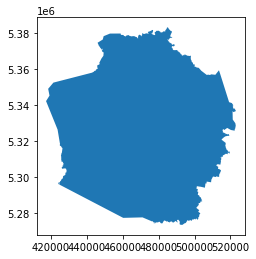

In [71]:
#plots extent of lga
ch_lga.plot()

In [72]:
#clips all state wide vector layers to central highlands lga subset
#https://geopandas.org/en/stable/docs/reference/api/geopandas.clip.html
land_clip = gpd.clip(land, ch_lga)
water_clip = gpd.clip(water, ch_lga)
roads_clip = gpd.clip(roads, ch_lga)
bhs_clip = gpd.clip(bhs, ch_lga)

<AxesSubplot:>

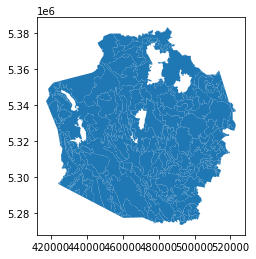

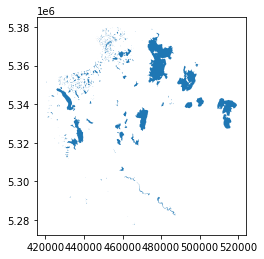

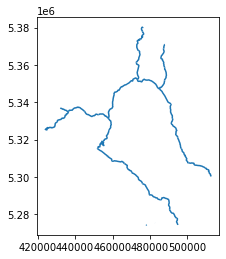

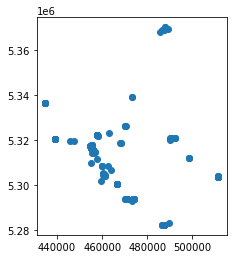

In [73]:
#plots clipped vector layers to see how this worked
#see https://geopandas.org/en/stable/gallery/spatial_joins.html
land_clip.plot()
water_clip.plot()
roads_clip.plot()
bhs_clip.plot()

In [74]:
#spatially joins between clipped land and water layers, shows table and check no. rows
join_lw = gpd.sjoin(land_clip, water_clip, how='inner', lsuffix='left', rsuffix='right')
print(join_lw.head())

            LS_REGION     RAINFALL            GEO_AGE  \
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   
1113  Central Plateau  1500-2000mm  Triassic-Jurassic   

                                      ROCK      ALTITUDE           LANDFORM  \
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   
1113  Metamorphic (e.g. quartzite, schist)  900 to 1200m  Undulating Plains   

                                               URL_LINK  \
1113  https://nrmdatalibrary.dpipwe.tas.gov.au/FactS...   
1113  https://nrmdatalibrary.dpipwe.tas.gov.au/FactS...   
1113 

In [75]:
len(join_lw)

659

In [76]:
#drops the index_right column in order to do second join (python wont allow multiple columns by same name)
join_lw.drop('index_right', axis=1, inplace=True)

In [77]:
#spatially joins bhs to landwater, check no of rows (376)
join_lwbhs = gpd.sjoin(bhs_clip, join_lw, how="inner", op="within")

In [78]:
print(join_lwbhs.head())

     DRILL_ID      NAME                   KEYWORDS              PURPOSE  \
220   15624.0  HEC-5018  Great Lake - Mt Blackwood  Engineering geology   
222   15629.0  HEC-5043           Great Lake North  Engineering geology   
223   15630.0  HEC-5083           Great Lake North  Engineering geology   
518   15625.0  HEC-5015           Great Lake North  Engineering geology   
520   15628.0  HEC-5041           Great Lake North  Engineering geology   

                       COMPANY DRILL_TYPE  DATE_DRILL  LENGTH  AZIMUTH   DIP  \
220  Hydro Electric Commission    Diamond  01/01/1955  160.00      0.0   0.0   
222  Hydro Electric Commission    Diamond     06/1955   38.00      0.0 -90.0   
223  Hydro Electric Commission    Diamond     05/1957  397.15      0.0 -90.0   
518  Hydro Electric Commission    Diamond     11/1954  107.59    360.0 -20.3   
520  Hydro Electric Commission    Diamond     04/1955   88.39      0.0 -90.0   

     ...                                           URL_LINK  WB_ID  

In [79]:
len(join_lwbhs)

376

In [80]:
#checks column index
join_lwbhs.columns

Index(['DRILL_ID', 'NAME', 'KEYWORDS', 'PURPOSE', 'COMPANY', 'DRILL_TYPE',
       'DATE_DRILL', 'LENGTH', 'AZIMUTH', 'DIP', 'RL', 'geometry',
       'index_right', 'LS_REGION', 'RAINFALL', 'GEO_AGE', 'ROCK', 'ALTITUDE',
       'LANDFORM', 'URL_LINK', 'WB_ID', 'WB_NAME', 'WB_AREA', 'WB_ELEV',
       'SUBCAT_ID', 'WB_MAP', 'WB_INFO', 'SHAPE_AREA', 'SHAPE_LEN'],
      dtype='object')

In [81]:
#drops unused columns to tidy table and better view data
join_lwbhs.drop(['index_right', 'URL_LINK', 'SUBCAT_ID', 'WB_MAP', 'WB_INFO', 'PURPOSE', 'COMPANY', 'DRILL_TYPE'], axis=1, inplace=True)


In [82]:
#prints unique values in each column
print(bhs_clip.nunique())

DRILL_ID      272
NAME          268
KEYWORDS       44
PURPOSE         1
COMPANY         5
DRILL_TYPE      7
DATE_DRILL    151
LENGTH        195
AZIMUTH        25
DIP            17
RL            126
geometry      167
dtype: int64


In [83]:
#prints unique values in each column
print(join_lw.nunique())

LS_REGION       3
RAINFALL        9
GEO_AGE         9
ROCK            9
ALTITUDE        5
LANDFORM        4
URL_LINK       52
geometry       70
WB_ID         579
WB_NAME       188
WB_AREA       579
WB_ELEV       578
SUBCAT_ID      37
WB_MAP         32
WB_INFO         1
SHAPE_AREA    579
SHAPE_LEN     579
dtype: int64


In [84]:
#prints unique values in each column
print(join_lwbhs.nunique())

DRILL_ID      148
NAME          147
KEYWORDS       31
DATE_DRILL    107
LENGTH        125
AZIMUTH        21
DIP            15
RL            101
geometry      116
LS_REGION       2
RAINFALL        6
GEO_AGE         6
ROCK            6
ALTITUDE        4
LANDFORM        3
WB_ID          20
WB_NAME        18
WB_AREA        20
WB_ELEV        20
SHAPE_AREA     20
SHAPE_LEN      20
dtype: int64


In [85]:
#prints head of join_lwbhs
print(join_lwbhs.head())

     DRILL_ID      NAME                   KEYWORDS  DATE_DRILL  LENGTH  \
220   15624.0  HEC-5018  Great Lake - Mt Blackwood  01/01/1955  160.00   
222   15629.0  HEC-5043           Great Lake North     06/1955   38.00   
223   15630.0  HEC-5083           Great Lake North     05/1957  397.15   
518   15625.0  HEC-5015           Great Lake North     11/1954  107.59   
520   15628.0  HEC-5041           Great Lake North     04/1955   88.39   

     AZIMUTH   DIP      RL                        geometry        LS_REGION  \
220      0.0   0.0     0.0  POINT (487937.625 5369993.885)  Central Plateau   
222      0.0 -90.0  1036.6  POINT (487212.623 5368733.883)  Central Plateau   
223      0.0 -90.0  1322.8  POINT (488992.627 5369423.884)  Central Plateau   
518    360.0 -20.3  1108.4  POINT (487672.624 5369853.885)  Central Plateau   
520      0.0 -90.0  1111.4  POINT (487372.624 5368793.883)  Central Plateau   

     ...             GEO_AGE                                      ROCK  \
220  .

In [86]:
print(join_lwbhs.groupby(['ROCK', 'GEO_AGE'])['DRILL_ID'].count())

ROCK                                               GEO_AGE                                           
Acid igneous (e.g. granite)                        Precambrian                                             1
Basic igneous (e.g. dolerite, basalt)              Cambrian                                               50
Metamorphic (e.g. quartzite, schist)               Triassic-Jurassic                                     117
Sedimentary arenaceous (e.g. sandstone)            Ordovician                                             92
Sedimentary argillaceous (e.g. mudstone)           Siliurian-Devonian                                     57
Sedimentary calcareous (e.g. limestone, dolomite)  Lower Devonian-Tremadocian-Cambrian (Mathinna bed*     59
Name: DRILL_ID, dtype: int64


In [87]:
# geo age and sum of bhs depth in each rock category in central highlands
print(join_lwbhs.groupby(['ROCK', 'GEO_AGE'])['LENGTH'].sum())

ROCK                                               GEO_AGE                                           
Acid igneous (e.g. granite)                        Precambrian                                             18.90
Basic igneous (e.g. dolerite, basalt)              Cambrian                                              1762.54
Metamorphic (e.g. quartzite, schist)               Triassic-Jurassic                                     2702.79
Sedimentary arenaceous (e.g. sandstone)            Ordovician                                            2234.04
Sedimentary argillaceous (e.g. mudstone)           Siliurian-Devonian                                    8641.28
Sedimentary calcareous (e.g. limestone, dolomite)  Lower Devonian-Tremadocian-Cambrian (Mathinna bed*    2433.84
Name: LENGTH, dtype: float64


In [88]:
#derives new data and insert a column with area_km2 into lw
#https://pandas.pydata.org/docs/getting_started/intro_tutorials/05_add_columns.html
join_lw["AREA_KM2"] = join_lw["SHAPE_AREA"] / 1000000

In [89]:
#checks landform category areas firstly group the data by class 
#https://autogis-site.readthedocs.io/en/latest/notebooks/L2/01-geopandas-basics.htmlhttp://localhost:8888/notebooks/egm722_assess_a.ipynb#
grouped_landform = join_lw.groupby('LANDFORM')

# then iterates over the group
for key, group in grouped_landform:

# checks how many rows each group has:
    print('Landform:', key)
    print('Number of rows:', len(group), "\n")

Landform: Hills (100-300m)
Number of rows: 45 

Landform: Low Hills (<100m)
Number of rows: 11 

Landform: Mountains (>300m)
Number of rows: 54 

Landform: Undulating Plains
Number of rows: 549 



In [90]:
#shows what area in km2 is covered by each land class
landform_area = grouped_landform.AREA_KM2.sum()
print(landform_area)

LANDFORM
Hills (100-300m)      821.532226
Low Hills (<100m)      92.692210
Mountains (>300m)      80.799374
Undulating Plains    1069.712269
Name: AREA_KM2, dtype: float64


In [91]:
#checks rock category areas, firstly group the data by class 
#https://autogis-site.readthedocs.io/en/latest/notebooks/L2/01-geopandas-basics.html
grouped_rock = join_lw.groupby('ROCK')

# then iterates over the group
for key, group in grouped_rock:

# checks how many rows each group has:
    print('Rock:', key)
    print('Number of rows:', len(group), "\n")

Rock: Acid igneous (e.g. granite)
Number of rows: 3 

Rock: Basic igneous (e.g. dolerite, basalt)
Number of rows: 4 

Rock: Complexes of the above &/or peat deposits
Number of rows: 404 

Rock: Metamorphic (e.g. quartzite, schist)
Number of rows: 124 

Rock: Quaternary
Number of rows: 4 

Rock: Sedimentary arenaceous (e.g. sandstone)
Number of rows: 17 

Rock: Sedimentary argillaceous (e.g. mudstone)
Number of rows: 39 

Rock: Sedimentary calcareous (e.g. limestone, dolomite)
Number of rows: 10 

Rock: Sedimentary rudaceous (e.g. conglomerate)
Number of rows: 54 



In [92]:
#shows what area in km2 is covered by each rock type class
rock_area = grouped_rock.AREA_KM2.sum()
print(rock_area)

ROCK
Acid igneous (e.g. granite)                           17.419091
Basic igneous (e.g. dolerite, basalt)                 13.222423
Complexes of the above &/or peat deposits            123.889119
Metamorphic (e.g. quartzite, schist)                 228.762810
Quaternary                                             0.329523
Sedimentary arenaceous (e.g. sandstone)              336.537513
Sedimentary argillaceous (e.g. mudstone)             952.490484
Sedimentary calcareous (e.g. limestone, dolomite)    357.465274
Sedimentary rudaceous (e.g. conglomerate)             34.619841
Name: AREA_KM2, dtype: float64


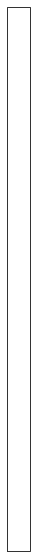

In [93]:
#creates a map view
myFig = plt.figure(figsize=(10, 10))

#defines my crs as UTM ref for Tasmania
myCRS = ccrs.UTM(55, southern_hemisphere=True)

#creates an axis on which to plot data
#ax = plt.axes(projection=myCRS) tired this, no diff
ax = plt.axes(projection=ccrs.UTM(55, southern_hemisphere=True))

In [94]:
# assigns and adds western highlands polygon from subset
ch_lga_feature = ShapelyFeature(ch_lga['geometry'], myCRS, edgecolor='k', facecolor='w')
xmin, ymin, xmax, ymax = ch_lga.total_bounds
ax.add_feature(ch_lga_feature) # add the outline feature to the map.http://localhost:8888/notebooks/egm722_assess_a.ipynb#

In [95]:
# using the boundary of the shapefile features, zooms the map to our area of interest
ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) # because total_bounds gives output as xmin, ymin, xmax, ymax,
# but set_extent takes xmin, xmax, ymin, ymax, we re-order the coordinates here.

In [96]:
#plots rock types; firstly defining how many unique rock types there are (9)
num_rock = len(land_clip.ROCK.unique())
print('Number of unique features: {}'.format(num_rock))

Number of unique features: 9


In [97]:
#selects colors for the 9 individual rock polygons
rock_colors = ['r','lightcoral','deeppink','darkviolet','dodgerblue','yellow','orange','mediumblue','green',]


In [98]:
#drops any null values from rock column (i.e. if polygons with no names exist)
#https://stackoverflow.com/questions/44681776/ignoring-nan-in-a-dataframe
rock_names = land_clip['ROCK'].dropna().unique()
rock_names.sort()
rock_names

array(['Acid igneous (e.g. granite)',
       'Basic igneous (e.g. dolerite, basalt)',
       'Complexes of the above &/or peat deposits',
       'Metamorphic (e.g. quartzite, schist)', 'Quaternary',
       'Sedimentary arenaceous (e.g. sandstone)',
       'Sedimentary argillaceous (e.g. mudstone)',
       'Sedimentary calcareous (e.g. limestone, dolomite)',
       'Sedimentary rudaceous (e.g. conglomerate)'], dtype=object)

In [99]:
#adds the rock polygon colours to the map using the colors above by iterating over the unique values in the 'ROCK' field
#also defines features characteristics
for i, name in enumerate(rock_names):
    feat = ShapelyFeature(land_clip['geometry'][land_clip['ROCK'] == name], myCRS,
                          edgecolor='k',
                          facecolor=rock_colors[i],
                          linewidth=1,
                          alpha=0.25)
    ax.add_feature(feat)

In [100]:
#adds remaining vectors to map
water_feat = ShapelyFeature(water_clip['geometry'], myCRS,
                            edgecolor='mediumblue',
                            facecolor='mediumblue',
                            linewidth=2)
ax.add_feature(water_feat)

roads_feat = ShapelyFeature(roads_clip['geometry'], myCRS,
                            edgecolor='black',
                            linewidth=1.5)

ax.add_feature(roads_feat)

In [101]:
#assigns and plots point data handles using ax.plot()
bhs_handles = ax.plot(bhs_clip.geometry.x, bhs_clip.geometry.y, 'h', ms=8, c='r', transform=myCRS)

#details a legend to match the colours plotted above
#generate a list of handles for the rock type
rock_handles = generate_handles(land_clip.ROCK.unique(), rock_colors, alpha=0.25)

#generates water handle
water_handles = generate_handles(['Lakes'], ['mediumblue'])

#generates roads handle
roads_handles = [mlines.Line2D([], [], color='black')]

In [102]:
#enables rock type polygons to be added to legend and updates ROCK names for consistency
nice_names = [name.title() for name in rock_names]

In [103]:
#ax.legend() takes a list of handles and a list of labels corresponding to the objects you want to add to the legend
handles = rock_handles + bhs_handles + water_handles + roads_handles
labels = nice_names + ['Boreholes', 'Lakes', 'Roads']

#adds legend
leg = ax.legend(handles, labels, title='Legend', title_fontsize=14,
                 fontsize=12, bbox_to_anchor=(1.04,0.7), loc='upper left', frameon=True, framealpha=1)

In [104]:
#adds a title
ax.set_title('Geological strata and borehole locations in Central Highlands, Tasmania', fontsize=16, pad=20)

Text(0.5, 1.0, 'Geological strata and borehole locations in Central Highlands, Tasmania')

In [105]:
#adds projected gridlines to map
gridlines = ax.gridlines(draw_labels=True,
                         xlocs=[146, 146.5, 147],
                         ylocs=[-42, -42.5])

gridlines.right_labels = False
gridlines.top_labels = False

ax.set_extent([xmin, xmax, ymin, ymax], crs=myCRS) # set the extent to the boundaries of the central highlands polygon

In [106]:
#adds bh label text
for i, row in bhs_clip.iterrows():
    x, y = row.geometry.x, row.geometry.y # get the x,y location for each bh
    ax.text(x, y, row['NAME'].title(), fontsize=8, transform=myCRS) # use ax.text to place a label at x,y

In [107]:
#add a scalebar from https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees) 
ax.add_artist(ScaleBar(1))

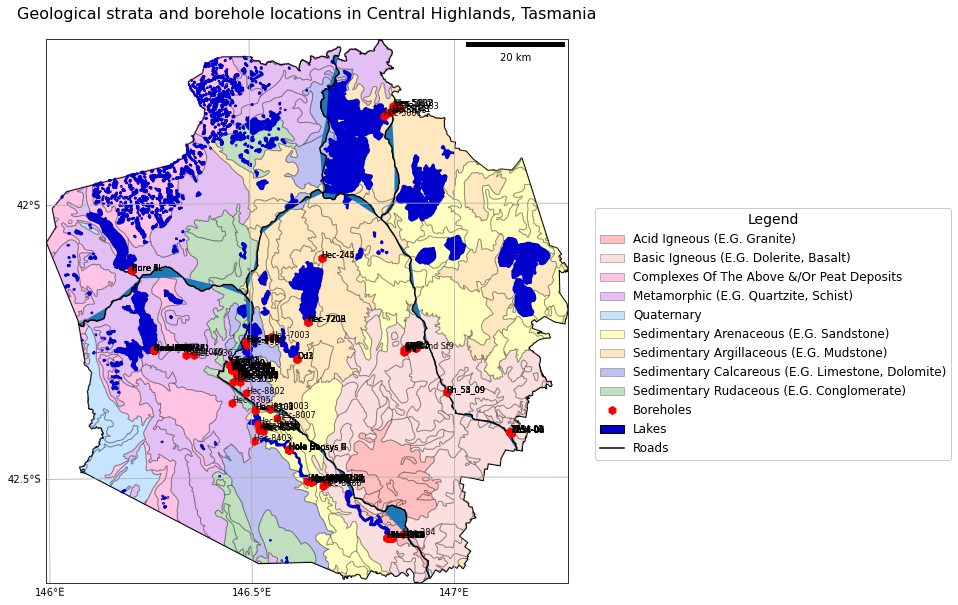

In [108]:
# shows figure here
myFig 

In [109]:
#saves figure
myFig.savefig('tas_geo.png', bbox_inches='tight', dpi=300)

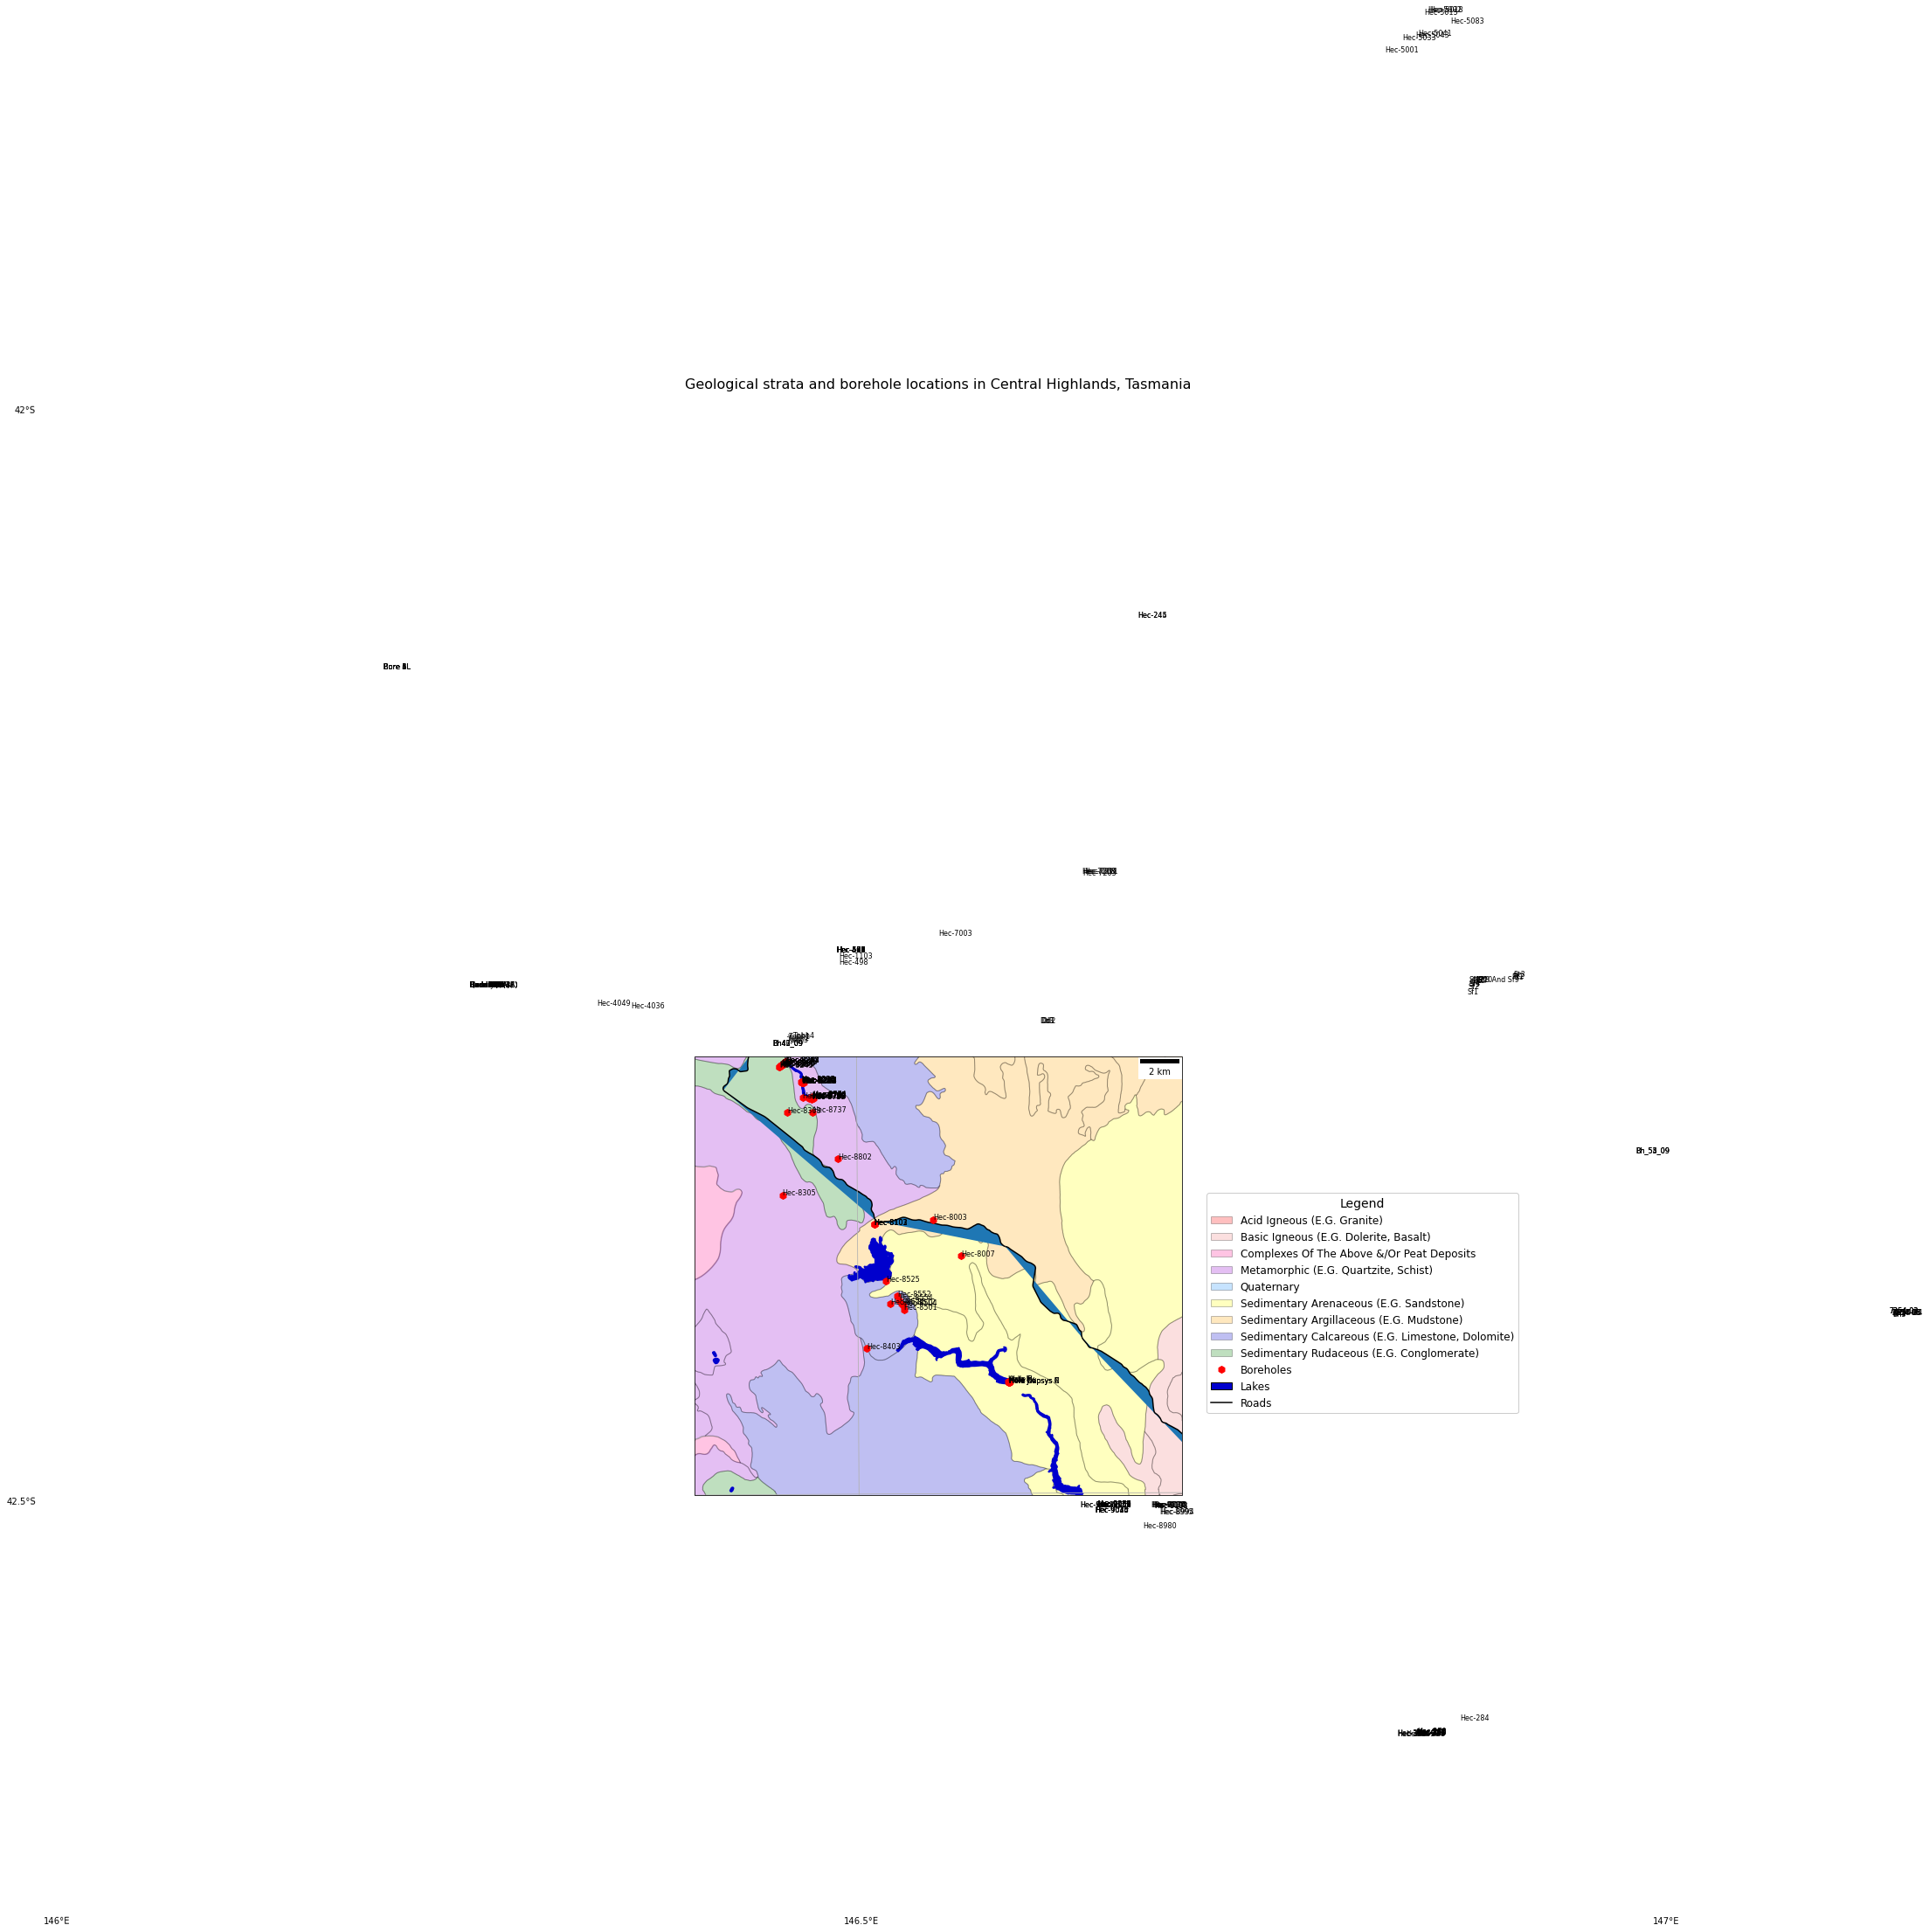

In [110]:
#zooms in on selected area
ax.set_extent([146.4, 146.7, -42.3, -42.5], crs=None) 
myFig